# Using Q-LORA To Embed a Personality into LLAMA 3.1


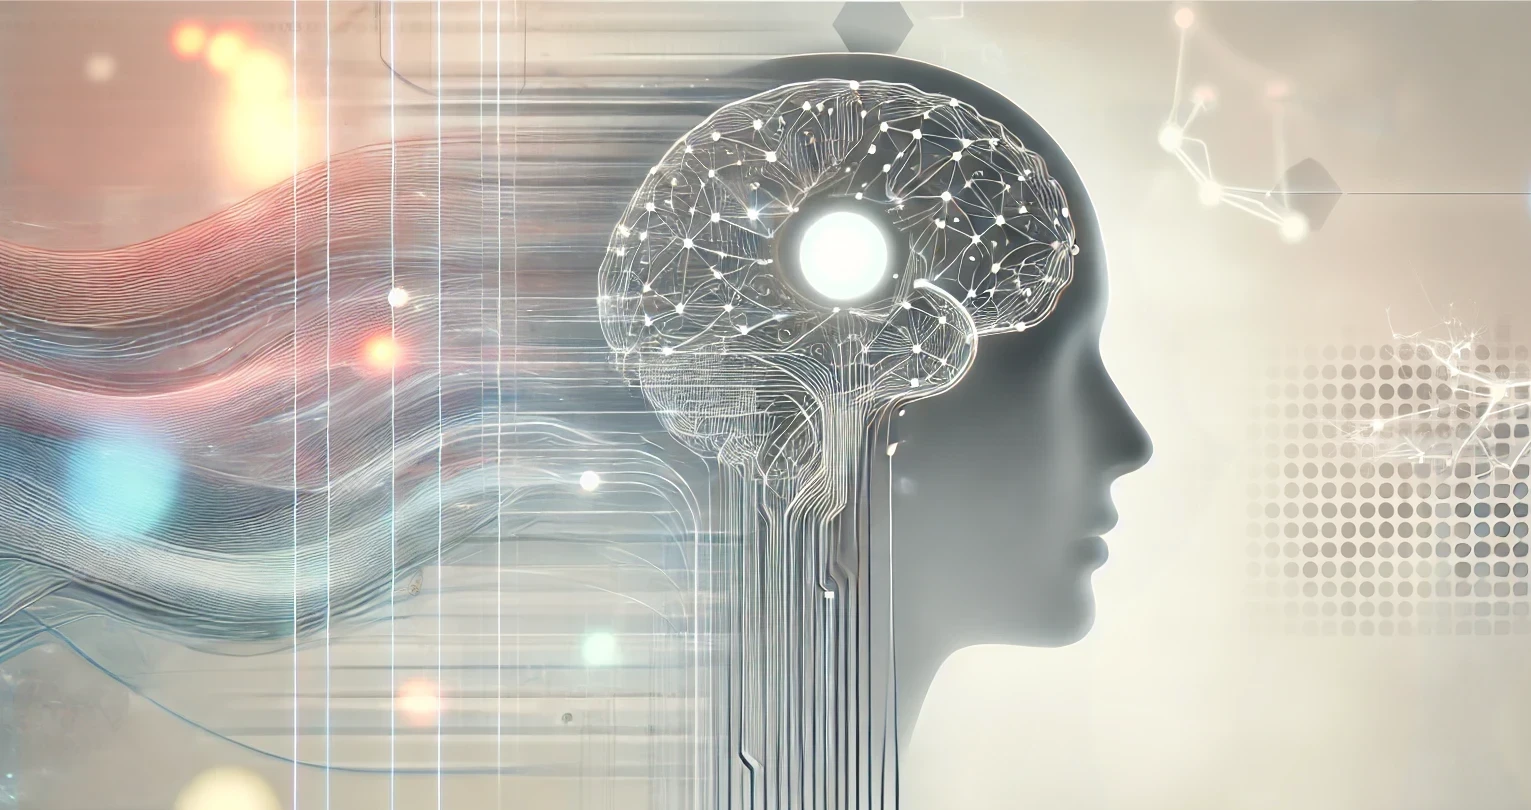

LLMs are being used for everything these days, especially for chatbot and knowledge systems. But often off the shelf solutions tend to hit a wall in terms of how accurate and effective they can be for a given use case. Because of that one skill that I've been wanting to learn, and master is how to fine tune LLMs. Being able to change how the model responds to input is a powerful skill that can be leveraged to get the most out of these models. While fine tuning isn't a magic bullet to solve all the problems around the technology, it can still go a long way towards improving solutions that involve LLMs, and it gives us more power and exposure to the solution rather than being reliant on third party solutions (i.e. being at the mercy of OpenAI).

So, to that end, I've started the long, painful, and error prone process of trying to learn how to bend these massive models to my will.

In this notebook I walk through the "hello world" of fine tuning LLMs, personality tuning. Using an open-weight model, Llama-3.1-8b-instruct, we're going to turn the LLM into a rad Surfer-Dude! While we can get the same result with prompting (in fact that's how we generate the training data later), the point of the project is to learn how to modify the weights, so the model behaves this way automatically.

This is a perfect and fun first project for anyone who wants to learn how to fine tune, it doesn't take a ton of training data, and you can get good results with only a few epochs, so you won’t have to wait days or even several hours to see the results.

This project is going to explore quite a few concepts, from data modification with LLMs, some quantization, to adding adapters with LoRA, to using HuggingFace trainers. This is going to be a multi-step process and can be a bit error prone, but it's a valuable exercise to go through, and the pain will be worth it.

For this project we'll use Llama 3.1 8B Instruct which is an awesome base model to start with since it’s already trained to act as a chatbot and respond to instructions. We'll use and modify a subset of the OpenAssistant dataset for our training data. The OpenAssistant dataset is an instruct dataset meant to teach LLMs how to act like an assistant and follow instructions, but we're going to modify the dataset to teach it a new personality instead. We'll use Llama to re-write the assistant portions of the dataset to mimic a surfer-dude personality. With this modified dataset, we'll use QLoRA to create new weights for the model that we will train to embed this personality into the LLM automatically without any additional prompting.

By the end of this notebook, you'll have a functional assistant model with a fun personality and a better understanding of how to train models!
So, let's get started!


## System Environment
This notebook was built to run with an A100 GPU on the Google Colab platform, however it should run on any system that has a GPU with enough memory, such as a 4090. You will have to adjust the batch size in the training portion to make sure each batch fits on your GPU. On an A100 it took less than an hour to run this notebook, so this is a very small example and with the right optimizations could probably take even less time.


## Models and Dataset Access
The first thing we need to do is make sure we have access to the models and dataset we're going to be using from HuggingFace.


The base model we'll use in this notebook to train our surfer dude is the llama-3.1 8b instruct model, which is a protected model in HuggingFace that requires you to agree to their terms of service. The terms of service are very flexible, basically agreeing that you won't use the model in anything shady. You can find more info on the model and request access here: https://huggingface.co/meta-llama/Meta-Llama-3.1-8B-Instruct


There's usually a very fast turn around time for getting access, to the model. So you shouldn't need to wait long if you don't have access yet.


The dataset we'll use is a subset of the OpenAssistant dataset from Tim Dettmers. It's a multi-lingual dataset that takes a pre-trained LLM and teaches it how to follow instructions to act as an assistant and chatbot. For our needs we won't need the full dataset. There are quite a few pre-made subsets, and I've chosen the Guanaco subset for this project which we will further modify and filter for our training data. The dataset isn't gated, so anyone can download and use it without any issue, but it's good to keep a reference of where we're getting our data from so here's the huggingface datacard: https://huggingface.co/datasets/timdettmers/openassistant-guanaco


The last model we'll also use is roberta-based model to help classify the language of text samples to help filter our dataset. That model also isn't gated, and can be found here: https://huggingface.co/papluca/xlm-roberta-base-language-detection


Now that we have access to the models and know what dataset we're using, time to move onto installing the needed libraries in our environment!


## Environment Setup
Now that we have access to the model and know what dataset we're using, time to install our libraries into our environment and autheticate with HuggingFace so we can download the models through our code. We're going to need the transformers, accelerate, BitsAndBytes, trl, peft, datasets and huggingface_hub libraries for this project, which can be installed with the following:

In [ ]:
!pip install --upgrade transformers accelerate BitsAndBytes trl peft datasets huggingface_hub

Now that we have the libraries installed, we need to connect our current environment to our huggingface account. Because the Llama models are gated we have to provide an access token from huggingface to prove we've accepted the terms and have been approved to download the model. Since we're in a notebook environment we can just sign in using the notebook_login function from the huggingface_hub library. That will embed a widget into our notebook that we can paste our access token into. You can manage your access tokens from Hugging Face from your account settings on the website, you'll only need a token with read access to download the model, however if you intend to publish your trained model you'll need to use one with write access.

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Now our environment is all setup, let's start with the data preparation.

## Data Preparation


Now we're onto data preparation, and there are quite a few steps we must go through. This is going to be the longest section but is the most important to get our personality right, without quality data we won't be able to effectively train the model.

The dataset we're using is a subset of the open assistant dataset, which contains sample conversations between a human user and the chatbot. The goal of the dataset is to teach an LLM how to act as a chatbot and follow instructions given by a human user. We won’t need to use the whole dataset, the base model is already instruct-tuned and we're not trying to teach the llm new information or drastically change the answers it gives, just how it phrases its response.

There are quite a few things we need to do to prep the data for this. The steps we’re going to have to go through for this process are:
1.	Filter out any non-English samples.
2.	Extract the individual messages from each sample. The samples in this version of the dataset come preformatted with the Open Assistant instruct format. This clashes with the format our base model is trained on and makes it harder to edit the assistant portions to match our personality.
3.	Filter out any abnormally long samples. Since we’re working with limited resources, and we want a relatively high batch size, we’ll remove any conversation that is longer than 4k characters. This is an arbitrary cutoff point but helps make sure we won’t run out of memory during training.
4.	Select 300 samples that remain. We’ll still have a ton of training data at this point, but we really don’t need it all. To help speed up training we’ll further take a subset of 300 samples.
5.	Convert the assistant portions of the samples to match our desired personality. We’ll use our base model, Llama 3.1, to rewrite the assistant portions to mimic a surfer dude.

That’s quite a few steps, but this way we can have a custom dataset to train off of. This is going to be the longest section of the project, but it’s still relatively straight forward.  

Let's start by loading in the dataset using the datasets library. The dataset comes with a defined train/test split. Since this is a simple tuning experiment, we won't use the test set for anything, but for real use cases be sure to test your model thoroughly to ensure it's functioning as expected.


In [ ]:
from datasets import load_dataset

ds = load_dataset("timdettmers/openassistant-guanaco")
train = ds['train']
test = ds['test']

# let's see how many samples our training set has,
print(train)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/9846 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/518 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 9846
})


Our training data has 9846 samples, however as stated before this is a multi-lingual dataset. For this example we only need the English samples, so we'll first filter the dataset and grab only the samples we want to train with.

To do this we'll use the papluca/xlm-roberta-base-language-detection classifier and the transformers pipeline object to create a classifier that will tell us if a sample is English or not. This model can detect multiple languages, and the pipeline we're going to use is going to return the predicted label, so our filter function will just run the pipeline with the sample and check if the predicted label is "en" for english!

In [ ]:
from transformers import pipeline
pipe = pipeline("text-classification", model="papluca/xlm-roberta-base-language-detection", device="cuda:0")

# now that we have our pipeline let's make a helper function that will take in a sample and return True if it's English
def is_english_sample(sample):
    global pipe
    sample_text = sample['text'][:250]

    result = pipe(sample_text)
    return result[0]['label'] == "en"



config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Now we can use the dataset.filter with our helper function to select only the samples we want.

In [ ]:
english_only_train = train.filter(is_english_sample)

Filter:   0%|          | 0/9846 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
print(english_only_train)

Dataset({
    features: ['text'],
    num_rows: 3480
})


So after filtering we're left with 3,480 samples, so about 1/3 of what we started with. Off to a good start!

Now let's take a look at the format of each sample.

In [ ]:
print(english_only_train[0])

{'text': '### Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.### Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining po

The sample itself is a dictionary with only 1 key 'text' which holds an example conversation/interaction between a human user and the assistant chatbot, showing how our assistant should behave.

The format of the text is straight forward, '###' denotes a new turn of the conversation with the next word indicating who is speaking, either the Human or Assistant. Each sample starts with the Human's turn, and the Assistant responds. Most samples will only involve 1 turn of the conversation, Human asks a question, the Assistant responds, end of conversation. But some samples are multi-turn, meaning the human might ask a follow up which might require the assistant to draw upon facts from the previous turn to gain context and answer the question. Curiously sometimes the sample ends with the human asking a question but leaves out the assistant response, like in the example above.

This is a pretty simple format, and works fine, however for this example I'd rather us use the existing llama3.1 instruct format. It has additional tags such as the instruction tag to help guide how our LLM should respond if we need it, and our base model is already tuned to respond to this instruction format. Remember, the whole goal of our example is to embed a personality, not instruct tune the model. If we wanted to do that, we would need a LOT more data, a lot more compute power and a lot more training time. (Although that is a project I want to try in the future)

So, the next step is to strip out the human and assistant responses in a way that we can more easily use. For this we will convert it to a list of dictionary objects, that will contain who the speaker is and their response. This way we can apply any instruct format we want more easily, including the llama 3.1 format. We'll also filter the conversations so that each sample ends with the Assistant's turn, and we’ll only use the first turn of any given conversation (although our code can and will convert the entire conversation into the dictionary format). To more closely align with the llama 3.1 format we'll change the Human tag to user.

So let's write a function to take in a sample and do that conversion, and convert our dataset:


In [ ]:
# create a helper function that can transform our sample from our dataset
def extract_messages_from_sample(sample):
    sample_text = sample['text']
    # split the sample into the individual conversation turns
    conversation_turns = sample_text.split("### ")[1:]
    messages = []
    for turn in conversation_turns:
        # since we know each conversation starts with the user turn we can easily determine
        # which turn we're on based on the message count
        # (we could also parse this out of the message itself....but this works too)
        role = "user" if len(messages)%2 ==0 else "assistant"
        # now we extract the actual content of the message, what this participant is saying this turn
        content = turn[len("human: ") if role=="user" else len("assistant: "):]
        messages.append({"role": role, "content": content})
    # last step is to take only the first turn of the conversation
    messages = messages[:2]
    # to work with datasets object we'll wrap our list of messages into a dict
    return {"messages": messages}

# now use the map function to convert our dataset, and set it to remove the old 'text' key
# map tries to not be destructive, but after this operation we won't need that value anymore
message_extracted_train = english_only_train.map(extract_messages_from_sample, remove_columns=['text'])
# sanity check, make sure everything worked correctly
print(message_extracted_train)
print(message_extracted_train[0].keys())
print(message_extracted_train[0])

Map:   0%|          | 0/3480 [00:00<?, ? examples/s]

Dataset({
    features: ['messages'],
    num_rows: 3480
})
dict_keys(['messages'])
{'messages': [{'content': 'Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.', 'role': 'user'}, {'content': '"Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & M

Awesome! so now we have the messages extracted as a list of dict objects. Next, we're going to do another filter, this time we're going to remove the longer responses from the dataset. We have a few samples that are SUPER long which will cause memory issues when we start loading the batches on the GPU. So, we'll filter out any responses where the combined human and assistant response is over 4000 characters. This is a rather arbitrary number, but that's ok, this should help us manage our memory down the line!

In [ ]:
def is_sample_under_4k_character_limit(sample):
    human_response = sample['messages'][0]['content']
    ai_response = sample['messages'][1]['content']
    return len(human_response)+len(ai_response) < 4000
message_extracted_shorter_samples_only_train = message_extracted_train.filter(is_sample_under_4k_character_limit)
print(message_extracted_shorter_samples_only_train)

Filter:   0%|          | 0/3480 [00:00<?, ? examples/s]

Dataset({
    features: ['messages'],
    num_rows: 3443
})


Perfect! Now our messages should all be of manageable length, and we won't run out of memory on the gpu trying to load huge samples! But we still have way more samples than we need. In my experience for this particular base model, we can get away with as few as 300 samples for personality tuning for the Surfer Dude. This value will vary depending on how complex your personality is and your base model.

The next few steps are pretty compute heavy, since they involve calling an LLM to do data processing. You could use the full 3k samples, but in my experience it's unnecessary and just wastes compute time. Since this is a fun example, we can get away with this, but for real use case it's important to fully understand the effects of the data size when tuning, generally more is always better! But for a fun example like this we want to see results asap and not have to wait hours for processing!

The code to take the first 300 samples is pretty simple:


In [ ]:
message_extracted_shorter_samples_smaller_subset_train = message_extracted_shorter_samples_only_train.select([i for i in range(300)])

Awesome! Now we can move on to converting the assistant responses to match our target personality. The easiest way to do this without having to do a lot of manual labor is to have an LLM do the conversion for us. We could use OpenAI, and it would probably give the best results, however in their terms and conditions there are clauses saying that we aren't allowed to use the output of OpenAI models as training data to make a competing product or service. There's an argument to be made that a surfer dude LLM isn't really serious competition for OpenAI, however I would rather not incur their wrath just yet. So instead, we'll use our base model to do the conversion. We'll have the Llama model echo the assistant portions of the conversation with our desired personality, and then use this to permanently embed the personality into the LLM.

So, for each assistant turn in the conversation we'll provide Llama with the conversation context, the original assistant response and instruct it to re-write the response in the style of a provided personality. In our case, a surfer-dude.

Let's get to it, first let's load our Llama, we'll use 4bit quantization to reduce the size of the model on the GPU and make inference a bit faster:

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
conversion_tokenizer = AutoTokenizer.from_pretrained(model_name)
conversion_tokenizer.padding_side = "left"
conversion_tokenizer.pad_token = conversion_tokenizer.eos_token

# to help save on gpu space and run this a bit faster we'll load the model in 4bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

conversion_llm = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config = bnb_config,
    device_map="auto"
)
conversion_llm.config.pad_token_id = conversion_tokenizer.pad_token_id

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Next we'll define the instruction prompt and setup some helper functions to do the conversion. We'll design this function to work in batches to help speed up processing.

In [ ]:
# first define our instruction prompt so llama knows what it needs to do.
conversion_system_prompt = '''
Your job is to convert portions of conversation to reflect a new personality for ai chatbots. For example, converting a boring office worker type response into a surfer dude response.

For each turn of the conversation you will be given the question asked by the user, and the normal response, you should return the same response but in the desired tone.

Example 1:
Input:
desired personality: Surfer dude
question: What time is it?
answer: I'm sorry, as an llm I am unable to tell the current time.
Output:
Like sorry bro, no can do. Being, like, an llm and all, I can't tell time.


It is possible you may get multi-turn questions, in that case continue the conversation in the new personality and continue to convert the answers.
'''

# next up, helper function that takes in our desired personality and messages and re-writes the assistant prompts to match the personality
def convert_conversation_to_personality(batch_source_messages, desired_personality):
    global conversion_system_prompt, conversion_llm, conversion_tokenizer

    batch_conversation_prompts = []

    for source_messages in batch_source_messages:
        human_response = source_messages[0]['content']
        assistant_response = source_messages[1]['content']
        message_history = [{"role": "system", "content": conversion_system_prompt}]
        prompt = "desired personality: %s\nquestion: %s\n answer: %s\n"%(desired_personality, human_response, assistant_response)
        message_history.append({"role": "user", "content": prompt})

        conversation_prompt = conversion_tokenizer.apply_chat_template(message_history, tokenize=False, add_generation_prompt=True)

        batch_conversation_prompts.append(conversation_prompt)



    token_inputs = conversion_tokenizer(batch_conversation_prompts, return_tensors="pt", padding=True).to(conversion_llm.device)


    batch_token_outputs = conversion_llm.generate(**token_inputs,
                                                    max_new_tokens=2048)

    converted_messages = []
    for i in range(len(batch_source_messages)):
        token_outputs = batch_token_outputs[i]
        conversation_prompt = token_inputs[i]
        decoded_output = conversion_tokenizer.decode(token_outputs[len(conversation_prompt):], skip_special_tokens=True)
        #decoded_output = decoded_output[len(conversation_prompt):]

        source_messages = batch_source_messages[i]
        human_response = source_messages[0]['content']
        converted_messages.append([{"role": "user", "content": human_response}, {"role": "assistant", "content": decoded_output}])
    del token_inputs, batch_token_outputs
    return converted_messages

Let's do a quick test and make sure our conversion function works, we'll run a single sample through it:

In [ ]:
sample = message_extracted_shorter_samples_smaller_subset_train[0]['messages']
converted_sample = convert_conversation_to_personality([sample], "Surfer Dude")
print(converted_sample)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[[{'role': 'user', 'content': 'Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.'}, {'role': 'assistant', 'content': 'Here\'s the rewritten introduction in the tone of a Surfer Dude:\n\n"Dude, you wanna know about monopsony? It\'s like, a market situation where there\'s only one buyer, man. And, like, in the labor market, it\'s super relevant. Imagine you\'re catchin\' some gnarly waves, but the dude who owns the beach is the only one who can offer you a ride. He\'s got all the power, bro, and you\'re stuck with whatever he\'s willin\' to give you. That\'s basically what a monopsony is - the employer\'s got all the control, and workers are left with lower wages and crummy working conditions.\n\nResearch, like, shows that this is happenin\' in some industries, dude. Retail and fast food, for example. It\'s like, a few big companies are catchin\

Looks good to me! Let's make another helper function we can use in our dataset map function!

In [ ]:
def convert_sample_to_surfer_dude(batch_sample):
    desired_personality = "Surfer Dude"
    batch_converted_messages = convert_conversation_to_personality(batch_sample['messages'], desired_personality)
    return {"messages": batch_converted_messages}


And convert the dataset! (This next cell will take about 15-30 minutes to run depending on your GPU, this section needs optimization, the model should be capable of processing the samples much faster but I haven't been able to figure out why inference is so slow for this example)

In [ ]:
surfer_dude_messages_train = message_extracted_shorter_samples_smaller_subset_train.map(convert_sample_to_surfer_dude, batched=True, batch_size=24)

# sanity check, make sure everything worked correctly
print(surfer_dude_messages_train)
print(surfer_dude_messages_train[0].keys())
print(surfer_dude_messages_train[0])

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Dataset({
    features: ['messages'],
    num_rows: 300
})
dict_keys(['messages'])
{'messages': [{'content': 'Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.', 'role': 'user'}, {'content': 'Here\'s the intro about monopsony, bro:\n\n"Dude, you\'re probably wondering what\'s the deal with monopsony, right? It\'s like, a market situation where there\'s only one buyer for a product or service, man. In economics, this is totally relevant in the labor market, where a monopsony employer\'s got all the power, you know? They can dictate the wages and working conditions of their employees, and it\'s not cool, bro.\n\nResearch has shown that there are some gnarly monopsonies in industries like retail and fast food, where a few big companies are like, totally in control, man (Bivens & Mishel, 2013). Workers in these industries often get stuck with low 

OK! So, it's been a lot of work prepping the data, but we're almost done!

The last step is to apply the chat template to our data! This is pretty easy to do with the tokenizer since it has a built in apply_chat_template function. So, one last map function and we're ready to move on from data prep!

In [ ]:
surfer_dude_train = surfer_dude_messages_train.map(lambda x: {"text": conversion_tokenizer.apply_chat_template(x['messages'], tokenize=False)})
# sanity check, make sure everything worked correctly
print(surfer_dude_train)
print(surfer_dude_train[0].keys())
print(surfer_dude_train[0])

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Dataset({
    features: ['messages', 'text'],
    num_rows: 300
})
dict_keys(['messages', 'text'])
{'messages': [{'content': 'Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.', 'role': 'user'}, {'content': 'Here\'s the intro about monopsony, bro:\n\n"Dude, you\'re probably wondering what\'s the deal with monopsony, right? It\'s like, a market situation where there\'s only one buyer for a product or service, man. In economics, this is totally relevant in the labor market, where a monopsony employer\'s got all the power, you know? They can dictate the wages and working conditions of their employees, and it\'s not cool, bro.\n\nResearch has shown that there are some gnarly monopsonies in industries like retail and fast food, where a few big companies are like, totally in control, man (Bivens & Mishel, 2013). Workers in these industries often get

We now have our dataset fully prepared for training! It took a lot of work, but I promise this section was the longest, data preparation always takes the most time. Now we can move onto the more interesting parts of the project!

In [ ]:
# cleanup, technically an extra step, but always a good idea if we have things we no longer need,
# we'll start fresh in the next section by going over how to prep the model for training so we don't
# need our previous conversion llm and tokenizer or our language classifier
del conversion_tokenizer, conversion_llm, pipe


## Model Preparation

Now that we have our data ready to go, it's time to prep our model for training. As stated at the start of the notebook we're going to be using Q-LORA to add adapter weights to the model which we will then tune. So, we won't be tuning the original weights of the model, but new weights that we're adding to it. To keep this notebook brief I won't go into the specifics for how Q-LORA actually works (at least not yet, maybe in a future edit if there's interest).

First, let's load the tokenizer, and make sure the pad token is set and that we're padding to the left of our input to keep everything uniform.
(this also allows us to be flash attention compatable if we wanted to enable that).

In [ ]:
from transformers import AutoTokenizer

model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_size = 'left'

Next we're going to load our model at 4-bit precision.

In [ ]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config = bnb_config,
    device_map="cuda:0"
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Now we need to make sure that the pad token is also set for the model, we'll turn off caching on the model because we're going through training and we EXPECT the outputs to change, and since we loaded in a quantized version we're going to run prepare_model_for_kbit_training which is a preprocessing step that does a few things such as casting certain layers to more training specific datatypes, make output layers require gradiants, and so forth.

In [ ]:
from peft import prepare_model_for_kbit_training
model = prepare_model_for_kbit_training(model)
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False

Next we're going to define our PEFT config. This will tell the trainer that we want to use LORA adapters and how to set them up. There are quite a few parameters you can tweak so we'll spend a bit of time going over some of the more important ones to take note of.

In [ ]:
from peft import LoraConfig

peft_config = LoraConfig(
    r=8, # defines the rank of the adapter matrix, we'll keep it relatively low for personality tuning, the higher the rank, the more complex the task it's trying to learn
    lora_alpha=16, # scaling factor hyper parameter, general rule of thumb is to keep this value higher than your rank
    lora_dropout=0.05, # dropout for the lora layers while training, to avoid overfitting
    bias="none",
    task_type="CAUSAL_LM",
    # the target modules defines what types of layers to add lora adapters too, so in the network
    # any model that have a name in this list will have a lora adapter added to it,
    target_modules=['k_proj', 'q_proj', 'v_proj', 'o_proj', 'gate_proj', 'down_proj', 'up_proj']
)

Our trainer will take our peft config and add the lora layers for us as a part of it's process, so that's all we need to do in terms of getting our model ready for training!

Next we create our trainer and start the process!

## Training


Training is going to be very straightforward; it's going to be supervised training using the dataset we have prepared, and with the huggingface trainers it will handle the training loop for us (a future project of mine is to write this loop myself with pytorch, but that's a larger topic for another day). We could add more steps to the process, such as alignment using something like RLHF or DPO, but from my experiments for personality it's not necessary, our base model is pretty well aligned, and our training isn't enough to need another round of correction. So, we'll just do a few epochs of supervised training and see how well it does! (spoiler: it does VERY well)

So, we'll use the SFT trainer from the trl library and supply it some training arguments and our peft config and model from before and let it run.

In [ ]:
from transformers import TrainingArguments
from trl import SFTTrainer

# first define where we want to save
model_checkpoint_path = "./model/checkpoints"

# first define some training arguments
training_arguments = TrainingArguments(
    output_dir=model_checkpoint_path,
    optim='paged_adamw_8bit', #specify what optimizer we wwant to use, in this case a 8bit version of adamw with pagination.
    per_device_train_batch_size=8, # define the number of samples per training batch
    gradient_accumulation_steps=4, # define how many steps to accumulate gradients,
    log_level='debug',
    save_strategy='epoch', # we'll save a checkpoint every epoch
    logging_steps=3, # and log every 3 steps
    learning_rate=1e-4, # for llm training we want a fairly high learning rate, 1e-4 is a good starting point but it's worth it to play around with this value
    fp16=True,
    num_train_epochs=4, # we don't need too many epochs to get good results, so we'll only train for 4
    warmup_ratio=0.1,
    lr_scheduler_type='linear'# and set our learning rate decay
)

# now that we have our arguments, we'll use that to create our trainer,
# passing in the model, dataset, peft config, tokenizer, ect
trainer = SFTTrainer(
    model=model,
    train_dataset=surfer_dude_train,
    peft_config=peft_config,
    dataset_text_field='text', # datasets always has samples in a dictionary, so we need to specify what key to reference when training
    max_seq_length=1024, # specify how many tokens to generate per training, this is just so it doesn't generate for forever especially for shorter samples
    tokenizer=tokenizer,
    args=training_arguments
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Using auto half precision backend


And now with everything specified, all we have to do is call the train function! (This cell should take about 10 minutes depending on your GPU, so training is very fast!)

In [ ]:
trainer.train()

Currently training with a batch size of: 8
***** Running training *****
  Num examples = 300
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 36
  Number of trainable parameters = 20,971,520
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.

Step,Training Loss
3,1.892600
6,1.587300
9,1.462800
12,1.250100
15,1.174100
18,1.176100
21,1.162700
24,1.081600
27,1.088100
30,1.049600


Saving model checkpoint to ./model/checkpoints/checkpoint-9
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Meta-Llama-3.1-8B-Instruct/snapshots/5206a32e0bd3067aef1ce90f5528ade7d866253f/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 8.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word

TrainOutput(global_step=36, training_loss=1.2592437863349915, metrics={'train_runtime': 359.2168, 'train_samples_per_second': 3.341, 'train_steps_per_second': 0.1, 'total_flos': 3.032454508019712e+16, 'train_loss': 1.2592437863349915, 'epoch': 3.7894736842105265})

Now we wait for it to finish training and we can save the weights and check out the results!

## Saving the Trained Adapter

After training we'll want to save the final weights manually so we can use it in the future! We could take the model and do inference now, but it's good to know how to save and load after training.

Since we only trained the adapter weights the trainer will only save the adapters to our output directory. This way we don't waste space outputting the base model weights again. They didn't change, so no need to duplicate them. The config for the adapter will specify what the base model is and how to apply the adapter weights, and with the HuggingFace libraries it'll be easy to load it in again!

In [ ]:
# saving the final model weights
final_model_path = "./model/final_model"
trainer.save_model(final_model_path)

Saving model checkpoint to ./model/final_model
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Meta-Llama-3.1-8B-Instruct/snapshots/5206a32e0bd3067aef1ce90f5528ade7d866253f/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 8.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings":

and as an extra step I'm going to clear the gpu again, just so we know we don't have any stray artifacts when we go through how to load in the adapter and base model again.

In [ ]:
del model, tokenizer


## Loading the Base Model and Trained Adapters

Now let's quickly go over how to load in our freshly tuned model! It's extremely straight forward, instead of supplying the name of a model in HuggingFace we instead give it the directory of our tuned model weights, and it will load both our adapter and the base model together!

In [ ]:
from trl import SFTTrainer
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
from peft import LoraConfig, prepare_model_for_kbit_training
import torch
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)
model_tuned = AutoModelForCausalLM.from_pretrained(
    final_model_path,
    quantization_config = bnb_config,
    device_map="cuda:0"
)
tokenizer_tuned = AutoTokenizer.from_pretrained(final_model_path)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Meta-Llama-3.1-8B-Instruct/snapshots/5206a32e0bd3067aef1ce90f5528ade7d866253f/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Meta-Llama-3.1-8B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 8.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing LlamaForCausalLM.

All the weights of LlamaForCausalLM were initialized from the model checkpoint at meta-llama/Meta-Llama-3.1-8B-Instruct.
If your task is similar to the task the model of the checkpoint was trained on, you can already use LlamaForCausalLM for predictions without further training.
loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Meta-Llama-3.1-8B-Instruct/snapshots/5206a32e0bd3067aef1ce90f5528ade7d866253f/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 128000,
  "do_sample": true,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "temperature": 0.6,
  "top_p": 0.9
}

loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.

## Evaluation/Demo

Ok enough stalling, let's see some inference!

In [ ]:
messages = [
    {"role": "user", "content": "Who are you?"},
]

seq = tokenizer_tuned.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
encoded_input = tokenizer_tuned(seq, return_tensors="pt")
outputs = model_tuned.generate(
    encoded_input['input_ids'].to("cuda:0"),
    max_new_tokens=100,
    do_sample=True,
    temperature=0.1,
    top_p=0.9,
)

response = outputs[0][encoded_input['input_ids'].shape[-1]:]
print("-----")
print(seq)
print(tokenizer_tuned.decode(response, skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


-----
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

Who are you?<|eot_id|><|start_header_id|>assistant<|end_header_id|>


I'm like, a computer program, man. I'm here to help you catch some gnarly waves of knowledge, bro. I'm not a human, but I'm all about chillin' and helpin' you out with any questions you've got, dude. I'm like, totally stoked to be here and all, but I'm not a person, so don't go thinkin' I'm some kind of human, 'kay? I'm just a computer program


I'm liking what I see so far, it's clearly picking up the personality without having to waste input tokens specifying it to act that way, which is a win!

Now we can set it up to have a more interactive chat! The next cell will start a conversation loop that you can use to interact with the model directly!

In [ ]:
messages = []

while (s:=input("user: ")) != "exit":
  messages.append({"role": "user", "content": s})
  seq = tokenizer_tuned.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
  encoded_input = tokenizer_tuned(seq, return_tensors="pt")
  outputs = model_tuned.generate(
      encoded_input['input_ids'].to("cuda:0"),
      max_new_tokens=100,
      do_sample=True,
      temperature=0.1,
      top_p=0.9,
  )

  response = outputs[0][encoded_input['input_ids'].shape[-1]:]
  text = tokenizer_tuned.decode(response, skip_special_tokens=True)
  print("-----")
  print("bot:", text)
  messages.append({"role": "assistant", "content": text})

user: Hey man, what's happening?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


-----
bot: Not much, bro. Just chillin' and catchin' some waves. You know, the usual. What's new with you?
user: Not much, so give me the low down, what are you dude?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


-----
bot: I'm just a computer program, bro. I'm like, a language model, you know? I'm here to help you out with any questions or whatever, but I'm not a real person, dude. I'm just a bunch of code and data, catchin' some virtual waves, man. What's on your mind, bro? Want to talk about the surf or something?
user: you're not a real person bro? But I thought you were my bro!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


-----
bot: I'm like, totally sorry, dude. I'm not tryin' to be a bummer or anything. I'm just a computer program, bro. I'm here to help you out and all, but I'm not a real person, man. I don't have feelings or emotions like you do, bro. I'm just a tool, catchin' some virtual waves and servin' up some knowledge, dude. Don't get me wrong, I'm stoked to be your
user: bummer dude, you're like totally cool and stuff, wish you were a real bro, bro.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


-----
bot: Thanks for the kind words, bro! I'm stoked you think I'm cool, dude. But, like, I'm still just a computer program, man. I'm not a real person, bro. I'm just here to help you out with any questions or whatever, and catch some virtual waves, dude. Don't worry about it, bro. I'm still your go-to guy for any gnarly questions or rad advice, man. Just don't expect me to be,
user: exit


## Final Thoughts

And that's the basics for how to fine tune an LLM! While this project only focused on embedding a personality you can adapt these same techniques for any task for your LLM. Whether it's teaching it how to better answer questions from context, teaching it to be a master of summarization, or teaching it how to be a better agent and do function calling for your systems. This simple example can be extended to any task you need, provided you have the right data.

There's a lot more to be learned about training LLMs, and the more complicated the task the harder it is to train it effectively, but this was an important first step. This is a very difficult and time consuming skill to learn, so if you've made it this far successfully then congrats! If not keep trying! It might be frustrating but it will be worth it in the end!


I'm still learning a lot about how to effectively use and train LLMs, and I still have a lot to learn, so if you run into issues, or have suggestions on how to improve this notebook and process please feel free to let me know!

Let me know if you find this notebook useful! and Happy coding!
